In [2]:
from google.colab import auth

auth.authenticate_user()

In [3]:
%%bash
pip3 install transformers emoji==0.6.0 keras_nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 100.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.
flax 0.6.11 requires jax>=0.4.2, but you have jax 0.3.25 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
orbax-checkpoint 0.2.6 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.


In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras_nlp
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
import transformers
from transformers import AutoTokenizer, TFAutoModel, AutoConfig, TFAutoModelForSequenceClassification
import matplotlib.pyplot as plt

In [5]:
# reproducibility
transformers.set_seed(0) # sets the seed in random, numpy, and tf

In [6]:
!gsutil cp "gs://cil_2023/train_pos_preprocessed.txt" .
!gsutil cp "gs://cil_2023/train_neg_preprocessed.txt" .

model_name = "vinai/bertweet-base"
filename_train_pos = "train_pos_preprocessed.txt"
filename_train_neg = "train_neg_preprocessed.txt"

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Copying gs://cil_2023/train_pos_preprocessed.txt...
\
Operation completed over 1 objects/82.2 MiB.                                     
Copying gs://cil_2023/train_neg_preprocessed.txt...
|
Operation completed over 1 objects/101.5 MiB.                                    


In [7]:
# read dataset
dataset_pos_pd = pd.read_fwf(filename_train_pos, sep='\n', header=None, names=['text'])
dataset_neg_pd = pd.read_fwf(filename_train_neg, sep='\n', header=None, names=['text'])
dataset_pos_pd['label'] = 0
dataset_neg_pd['label'] = 1
dataset_pd = pd.concat([dataset_pos_pd, dataset_neg_pd])

# shuffle
dataset_pd = dataset_pd.sample(frac=1, random_state=0).reset_index(drop=True)

# tokenize data set
tokenizer = AutoTokenizer.from_pretrained(model_name)
texts = tokenizer.batch_encode_plus(dataset_pd['text'].tolist(),
                                    padding=True, truncation=True,
                                    return_tensors='tf')

dataset = tf.data.Dataset.from_tensor_slices((dict(texts), dataset_pd['label']))

# split training / validation
batch_size = 32 * tpu_strategy.num_replicas_in_sync
AUTOTUNE = tf.data.experimental.AUTOTUNE

val_data_size = int(0.1 * len(dataset_pd.index))
train_data_size = len(dataset_pd.index) - val_data_size
val_ds = dataset.take(val_data_size).batch(batch_size, drop_remainder=True)
train_ds = dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
"""
  GRU-READ
"""
class GRUModel(tf.keras.Model):
  def __init__(self, model_name, num_labels, num_gru_units=32):
    super().__init__()

    self.num_labels = num_labels
    self.num_gru_units = num_gru_units

    self.encoder = TFAutoModel.from_pretrained(model_name, config=AutoConfig.from_pretrained(model_name, output_hidden_states=True))
    self.encoder.trainable = False

    self.norm = tf.keras.layers.LayerNormalization()
    self.linear = tf.keras.layers.Dense(2 * num_gru_units) # joiner network
    self.gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_gru_units, return_sequences=True, return_state=True))

    self.classifier = tf.keras.layers.Dense(num_labels, activation='softmax')

  def call(self, input):
    xs = self.encoder(input, return_dict=True).hidden_states
    batchsize = xs[0].shape[0]
    h = None
    sequence = tf.zeros(shape=(batchsize, xs[0].shape[1], 2 * self.num_gru_units))
    for i in range(len(xs)):
      sequence, h1, h2 = self.gru(self.norm(tf.keras.layers.Add()([self.linear(xs[i]), sequence])), initial_state=h)
      h = [h1, h2] # h = final state

    return self.classifier(tf.reshape(tf.stack(h, axis=-1), shape=[batchsize, -1]))

"""
  GRU-READ with MC-Dropout
"""
class GRUMCModel(tf.keras.Model):
  def __init__(self, model_name, num_labels, num_gru_units=32, num_forward_passes=100):
    super().__init__()

    self.num_labels = num_labels
    self.num_forward_passes = num_forward_passes
    self.num_gru_units = num_gru_units

    self.encoder = TFAutoModel.from_pretrained(model_name, config=AutoConfig.from_pretrained(model_name, output_hidden_states=True))
    self.encoder.trainable = False

    self.norm = tf.keras.layers.LayerNormalization()
    self.dropout = tf.keras.layers.Dropout(0.1)

    self.linear = tf.keras.layers.Dense(2 * num_gru_units) # joiner network
    self.gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=num_gru_units,
                                                                 dropout=0.1, recurrent_dropout=0.1,
                                                                 return_sequences=True, return_state=True))

    self.classifier = tf.keras.layers.Dense(num_labels, activation='softmax')

  def _forward(self, xs):
    h = None
    sequence = tf.zeros(shape=(xs[0].shape[0], 64))
    for i in range(len(xs)):
      sequence, h1, h2 = self.gru(self.norm(tf.keras.layers.Add()([self.linear(xs[i]), sequence])),
                                  initial_state=h, training=True)
      h = [h1, h2] # h = final state
    return self.classifier(tf.reshape(tf.stack(h, axis=-1), shape=[32, -1]))

  def call(self, input, training):
    xs = self.encoder(input, return_dict=True).hidden_states

    if training:
      return self._forward(xs)
    else:
      ys = []
      for i in range(self.num_forward_passes):
        ys.append(self._forward(xs))
      return tf.keras.layers.Average()(ys)



# functions that produce distributions for weights in DenseVariational layer of VGRUModel
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model =  tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

"""
  GRU-READ with DenseVariational layer as classifier
"""
class VGRUModel(tf.keras.Model):
  def __init__(self, model_name, num_labels, num_forward_passes=1000, num_gru_units=32):
    super().__init__()

    self.num_labels = num_labels
    self.num_forward_passes = num_forward_passes
    self.num_gru_units = num_gru_units

    self.encoder = TFAutoModel.from_pretrained(model_name, config=AutoConfig.from_pretrained(model_name, output_hidden_states=True))
    self.encoder.trainable = False

    self.linear = tf.keras.layers.Dense(2 * self.num_gru_units) # joiner network
    self.gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.num_gru_units, return_sequences=True, return_state=True))

    self.norm = tf.keras.layers.LayerNormalization()

    self.dense_var = tfp.layers.DenseVariational(self.num_labels, activation='softmax',
                                                 make_posterior_fn=posterior, make_prior_fn=prior,
                                                 kl_weight=1/train_data_size)

  def call(self, input, training):
    xs = self.encoder(input, return_dict=True).hidden_states
    batchsize = xs[0].shape[0]
    h = None
    sequence = tf.zeros(shape=(xs[0].shape[0], 2 * self.num_gru_units))
    for i in range(len(xs)):
      sequence, h1, h2 = self.gru(self.norm(tf.keras.layers.Add()([self.linear(xs[i]), sequence])), initial_state=h)
      h = [h1, h2]
    x = tf.reshape(tf.stack(h, axis=-1), shape=[batchsize, -1])

    if training:
      return self.dense_var(x)
    else:
      probs_samples = []
      for _ in range(self.num_forward_passes):
        probs_samples.append(self.dense_var(x))
      return tf.keras.layers.Average()(probs_samples)


In [14]:
"""
  Baseline model where Bertweet is finetuned directly
"""
with tpu_strategy.scope():
  basemodel = TFAutoModelForSequenceClassification.from_pretrained(model_name, config=AutoConfig.from_pretrained(model_name))
  basemodel.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, amsgrad=False, clipnorm=1.),
      metrics=[tf.metrics.SparseCategoricalAccuracy()]
  )

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
with tpu_strategy.scope():
  model = GRUModel(model_name, 2, num_gru_units=8)
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=False, clipnorm=None),
      metrics=[tf.metrics.SparseCategoricalAccuracy()]
  )

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/3
8789/8789 [==============================] - 761s 81ms/step - loss: 0.2671 - sparse_categorical_accuracy: 0.8851 - val_loss: 0.2435 - val_sparse_categorical_accuracy: 0.8972
Epoch 2/3
8789/8789 [==============================] - 693s 79ms/step - loss: 0.2505 - sparse_categorical_accuracy: 0.8930 - val_loss: 0.2390 - val_sparse_categorical_accuracy: 0.8995
Epoch 3/3
8789/8789 [==============================] - 687s 78ms/step - loss: 0.2464 - sparse_categorical_accuracy: 0.8951 - val_loss: 0.2367 - val_sparse_categorical_accuracy: 0.9008
Validation accuracy in each epoch: [0.897172749042511, 0.8994981050491333, 0.9007908701896667]


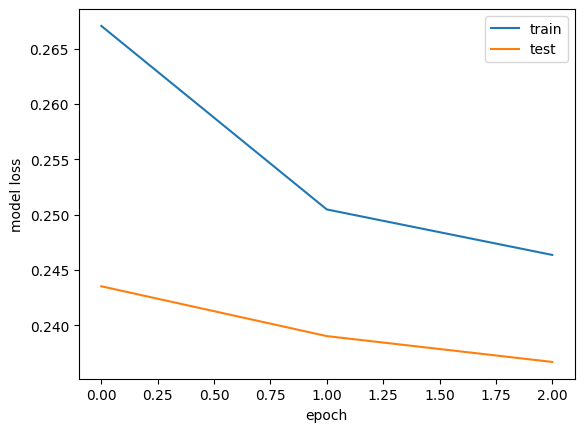

In [ ]:
# train model
history = model.fit(train_ds, validation_data=val_ds, epochs=3, verbose=1)

model.save_weights('./saved_weights.h5')

print("Validation accuracy in each epoch:", history.history['val_sparse_categorical_accuracy'])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')

plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('train_history.png')
plt.show()

In [11]:
model.summary()

Model: "gru_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_roberta_model (TFRobert  multiple                  134899968 
 aModel)                                                         
                                                                 
 layer_normalization (Layer  multiple                  128       
 Normalization)                                                  
                                                                 
 dense (Dense)               multiple                  49216     
                                                                 
 bidirectional (Bidirection  multiple                  18816     
 al)                                                             
                                                                 
 dense_1 (Dense)             multiple                  130       
                                                         